In [1]:
import torch
torch.set_grad_enabled(False)

In [2]:
# !cp -r /home/galqiwi/root/vcs_projects/linear-layer-compression-Andrei/Andrei/gptq/gptq.py ./
# !cp -r /home/galqiwi/root/vcs_projects/linear-layer-compression-Andrei/Andrei/gptq/edenn.py ./

In [2]:
xtx_dict = torch.load('/home/galqiwi/root/vcs_projects/linear-layer-compression-Andrei/Andrei/gptq/xtx_0.pt')

In [3]:
import transformers

model = transformers.AutoModelForCausalLM.from_pretrained(
    '/mnt/LLM/hub/models--meta-llama--Meta-Llama-3.1-8B/snapshots/48d6d0fc4e02fb1269b36940650a1b7233035cbb/',
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
weight = model.model.layers[0].self_attn.k_proj.weight
xtx = xtx_dict['self_attn.k_proj']
# xtx = torch.diag(10 ** torch.linspace(0, 10, len(xtx)))

In [5]:
weight = weight.cuda()
weight = torch.randn_like(weight)
xtx = xtx.cuda()

In [6]:
def fix_scale(value):
    return value / value.norm() * torch.nn.Linear(*value.shape).weight.norm()

xtx = fix_scale(xtx)

In [7]:
from gptq import apply_gptq
from edenn import edenn, pad_to_block, HadLinear

In [8]:
l_xtx = torch.linalg.cholesky(xtx)

In [12]:
import requests
from ast import literal_eval
import pandas as pd

grids = literal_eval(requests.get(
    'https://gist.githubusercontent.com/BlackSamorez/c74f24a648eb8bbfbbbf83f3145ba3c7/raw/ddc3280a4861938e2e2034c29d6802817e26e799/gistfile1.txt'
).text)

grids = pd.DataFrame(grids)
grids['name'] = grids.apply(
    lambda row: 'edenn_d=' + str(row['edenn_d']) + ';edenn_n=' + str(row['edenn_n']),
    axis=1,
)
grids = grids[['bits', 'mse', 'name']]
print(len(grids))
grids.sample(3)


75


,bits,mse,name
8,5.00,0.002038,edenn_d=2.0;edenn_n=1024.0
39,0.75,0.465032,edenn_d=4.0;edenn_n=8.0
15,6.00,0.000582,edenn_d=2.0;edenn_n=4096.0


In [ ]:
grids.sort_values('bits').tail(30).head(15)

In [48]:
had_block_size = 1024

dequantized_times = HadLinear(apply_gptq(
    weight @ l_xtx, torch.eye(len(xtx), device='cuda'),
    edenn_d=3, edenn_n=512,
    had_block_size=had_block_size,
), had_block_size)(torch.eye(*xtx.shape, device='cuda')).T.contiguous()

dequantized = HadLinear(apply_gptq(
    weight, xtx,
    edenn_d=3, edenn_n=512,
    had_block_size=had_block_size,
), had_block_size)(torch.eye(*xtx.shape, device='cuda')).T.contiguous()

GPTQ blocks...:   0%|          | 0/22 [00:00<?, ?it/s]

GPTQ blocks...:   0%|          | 0/22 [00:00<?, ?it/s]

In [49]:
old_relative_mse = ((dequantized_times - weight @ l_xtx).norm() / (weight @ l_xtx).norm()) ** 2
old_relative_mse

tensor(0.0267, device='cuda:0')

In [50]:
mse = (
    (dequantized @ l_xtx - weight @ l_xtx).norm() /
    weight.norm()
) ** 2 / (torch.logdet(xtx) / len(xtx)).exp().item()

mse

tensor(0.3371, device='cuda:0')

In [51]:
mse / old_relative_mse

tensor(12.6391, device='cuda:0')

In [58]:
print([[-1, -1]] * 224)

[[-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1],

In [47]:
mse = (
    (dequantized @ l_xtx - weight @ l_xtx).norm() /
    (weight @ l_xtx).norm()
) ** 2
mse

tensor(0.0004, device='cuda:0')

In [37]:
eigenvalues = torch.linalg.svd(xtx).S

In [55]:
eigenvalues.log().mean().exp()

tensor(0.0002, device='cuda:0')

In [56]:
eigenvalues.mean()

tensor(0.0304, device='cuda:0')

In [ ]:
eigenvalues

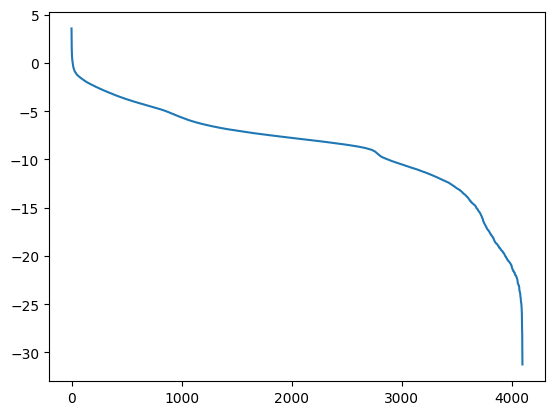

In [40]:
import matplotlib.pyplot as plt
plt.plot(eigenvalues.cpu().log().numpy())